# Panel 3

### `import packages.needed`

In [4]:
%matplotlib inline
%matplotlib ipympl
#
from lrgsglib.core import *
#
move_to_rootf()
plt.style.use('ipynb/nb_plotsheet.mplstyle')
#
path_paper = PATHPLOT / Path(PATHNPAPR)
path_panel3 = path_paper / Path('panel_3')
path_isingXERR = Path("data", "cluster_data")#path_panel3 / Path('isingXERR')
#
datpath = os.path.join('data')
subdatapath = os.path.join('plot', 'paper', 'panel_3/')
Isingdatapath = os.path.join(subdatapath, 'Ising')
plotpath = os.path.join(datpath, Isingdatapath)
plot_ene = os.path.join(plotpath, "plot_ene", "")
plot_phd = os.path.join(plotpath, "plot_ph_dia", "")
plot_eigV = os.path.join(plotpath, "plot_energy_eigV", "")
clusterdatapath = os.path.join('cluster_data', 'cluster_data_ising')

#
os.makedirs(plot_ene, exist_ok=True)
os.makedirs(plot_eigV, exist_ok=True)
os.makedirs(plot_phd, exist_ok=True)

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


## Fig. (a): Phase Diagram 
Expressions for the nishimori line as function of $T$ and $p$

$$\mathrm{nishi}_p(T)=\frac12​(1+e^{k_B ​TJ}​)-1,\qquad
\mathrm{nishi}_T(p) = \frac{J}{k_B \ln\left(\frac{1}{2p} - 1\right)}$$

In [ ]:
J = 1
k_B = 1
p_c = 0.103
nishi_p = lambda T: 0.5 * (1 + np.exp(J / (k_B * T)))**(-1)
nishi_T = lambda p: J * (k_B*np.log(1/(2*p)-1))**(-1)
#
T_c = 2.2
T_max = 2.5
p_max = 0.5
TlinSpace = np.linspace(1e-2, T_max, 100)
pSglinSpace = np.linspace(p_c, p_max)
TSglinSpace = 0*np.ones(len(pSglinSpace))
#
critPoints = np.array([[0, p_c], [T_c, 0]])

In [ ]:
kwNishiLine = dict(ls='-.', lw=1, marker='', c='k', clip_on=True)
kwCritPoints = dict(marker='o', c='r', clip_on=False, zorder=1e3)
kwSgLine = dict(lw=2, ls='-', c='#8030ff', marker='', clip_on=False, zorder=9e1)
#
fig, ax = plt.subplots(figsize=(8, 5))
#
ax.plot(nishi_p(TlinSpace), TlinSpace, **kwNishiLine)
ax.scatter(*critPoints, **kwCritPoints)
ax.plot(pSglinSpace, TSglinSpace, **kwSgLine)
ax.set_ylim(0, T_max)
ax.set_xlim(0, p_max)
# |#
ax.set_xticks([0, p_c, 0.4, 0.5])
ax.set_yticks([0, T_c])
ax.set_xticklabels([r"0", r"\(p_{\mathrm{c}}\)", r"0.4", r"0.5"])
ax.set_yticklabels([r"0", r"\(T_{\mathrm{c}}^{\text{\Large Ising}}\)"])
#
ax.tick_params(axis='both', which='both', labelsize=30)
#
ax.text(p_max/3, T_max/2, r'\emph{Nishimori Line}', fontsize=16)
ax.text(p_c, 0.1, r'\emph{Spin Glass}', c='#8030ff', fontsize=20)
#
fig.savefig(os.path.join(plot_phd, 'phase_diagram.pdf'), 
            bbox_inches='tight', transparent=True)
plt.close('all')

## Energy shots comparison

### X frames

In [ ]:
side = 48
pflip = 0.1
geo = 'squared'
cell = 'rand'
runlang = 'C3'
howmany = 100
numEigVdat = 5
thrmSTEP = 80
eqSTEP = 0
T_0 = 0.1
T_c = 2/np.log(1 + np.sqrt(2))
T_F = 3
Tlist = np.concatenate([np.linspace(T_0, T_c, 10), np.linspace(T_c, T_F, 3)])
l2dDict = dict(side1=side, geo=geo, pflip=pflip,# sgpath=Isingdatapath, 
               init_nw_dict=True)
#
l = Lattice2D(**l2dDict)
l.flip_sel_edges(l.nwDict[cell]['G'])
l.compute_k_eigvV(howmany=howmany)
energies = np.array([l.compute_rbim_energy_eigV(_)/2 for _ in range(howmany)])
eigVidxs = np.argsort(energies)[:numEigVdat]

In [ ]:
l.compute_rbim_energy_eigV(0)

In [ ]:
for ii, i in enumerate(eigVidxs):
    for T in Tlist:
        outs = f'{cell[-4:]}{thrmSTEP}gs{i}'.replace('.', '')
        fname = f'sout_p={pflip:.3g}_T={T:.3g}_{outs}'+BIN
        if os.path.exists(os.path.join(l.isingpath, fname)):
            continue
        idstr = f'{cell}'
        isd = IsingDynamics(l, T=T, ic=f'ground_state_{i}', runlang=runlang,
                            id_string=idstr, out_suffix=outs)
        l.export_edgel_bin(exName=idstr)
        isd.run(thrmSTEP=thrmSTEP, eqSTEP=eqSTEP)
        #begin cooling
        init = isd.s
        isd2 = IsingDynamics(l, T=T_0, ic=f'custom', runlang=runlang,
                    id_string=idstr, out_suffix=outs+f"cooling_{T:.3g}")
        isd2.init_ising_dynamics(init)
        isd2.run(thrmSTEP=thrmSTEP, eqSTEP=eqSTEP)
        isd.remove_run_c_files()
        isd2.remove_run_c_files()

In [ ]:
Tset = list(set(extract_values_from_filenames(os.listdir(l.isingpath), 
                                              r"T=([\d.]+)_")))

In [ ]:
T = Tset[0]
gs = eigVidxs[0]
outs = f'{cell[-4:]}{thrmSTEP}gs{gs}_{seed}'.replace('.', '')
frames = np.fromfile(os.path.join(l.isingpath, 
                                  f'sout_p={pflip:.3g}_T={T:.3g}_{outs}'+BIN), 
                                  dtype=np.int8).reshape(-1, *l.syshape)
coolingFname = f'sout_p={pflip:.3g}_T={0.1:.3g}_{outs}_cooling_{T:.3g}'+BIN
frames2 = np.fromfile(os.path.join(l.isingpath, coolingFname),
                      dtype=np.int8).reshape(-1, *l.syshape)

In [ ]:
fig, ax = plt.subplots(4, len(frames)//2, figsize=(12, 8))
coutn = 0
for axx in ax:
    for axxx in axx:
        axxx.axis('off'), 
        axxx.imshow(frames[coutn] if coutn < len(frames) else frames2[coutn-len(frames)], cmap=credcblu)
        coutn += 1
fig.tight_layout()
fig.savefig(os.path.join(plot_eigV, f'{side}_{cell}_{seed}_{thrmSTEP}_T={T:.3g}_gs{gs}.pdf'))

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
for T in Tlist[::2]:
    frames = np.fromfile(os.path.join(l.isingpath, 
                                  f'ene_p={pflip:.3g}_T={T:.3g}_{outs}'+BIN), 
                                  dtype=float)
    ax.plot(frames/4, ls='-', marker='', zorder=1/T, label=fr'$T={T:.3g}$', rasterized=True)
ax.set_xlabel(r'MC steps ($\Delta t = 1/N$)')
ax.set_ylabel(r'$E/N$')
ax.legend(fontsize=35, loc='upper right')
fig.savefig(os.path.join(plot_ene, f'{side}_{cell}_{seed}_{thrmSTEP}_T={T:.3g}_gs{gs}.pdf'), transparent=True)

### S frames

In [ ]:
side = 48
pflip = 0.1
geo = 'squared'
cell = 'rand'
runlang = 'C3'
howmany = 100
numEigVdat = 5
thrmSTEP = 80
eqSTEP = 0
seed = 654321
T_0 = 0.1
T_c = 2/np.log(1 + np.sqrt(2))
T_F = 3
Tlist = np.concatenate([np.linspace(T_0, T_c, 10), np.linspace(T_c, T_F, 3)])
l2dDict = dict(side1=side, geo=geo, pflip=pflip, sgpath=Isingdatapath, 
               init_nw_dict=True, seed=seed)
#
l = Lattice2D(**l2dDict)
l.flip_sel_edges(l.nwDict[cell]['G'])
l.compute_k_eigvV(howmany=howmany)
energies = np.array([l.compute_rbim_energy_eigV(_)/2 for _ in range(howmany)])
eigVidxs = np.argsort(energies)[:numEigVdat]

In [ ]:
for ii, i in enumerate(eigVidxs):
    for T in Tlist:
        outs = f'{cell[-4:]}{thrmSTEP}gs{i}_{seed}'.replace('.', '')
        fname = f'sout_p={pflip:.3g}_T={T:.3g}_{outs}'+BIN
        if os.path.exists(os.path.join(l.isingpath, fname)):
            continue
        idstr = f'{cell}_{seed}'
        isd = IsingDynamics(l, T=T, ic=f'ground_state_{i}', runlang=runlang,
                            id_string=idstr, out_suffix=outs)
        l.export_edgel_bin(exName=idstr)
        isd.run(thrmSTEP=thrmSTEP, eqSTEP=eqSTEP)
        #begin cooling
        init = isd.s
        isd2 = IsingDynamics(l, T=T_0, ic=f'custom', runlang=runlang,
                    id_string=idstr, out_suffix=outs+f"_cooling_{T:.3g}")
        isd2.init_ising_dynamics(init)
        isd2.run(thrmSTEP=thrmSTEP, eqSTEP=eqSTEP)
        isd.remove_run_c_files()
        isd2.remove_run_c_files()

In [ ]:
Tset = list(set(extract_values_from_filenames(os.listdir(l.isingpath), r"T=([\d.]+)_")))

In [ ]:
T = Tset[2]
gs = eigVidxs[0]
outs = f'{cell[-4:]}{thrmSTEP}gs{gs}_{seed}'.replace('.', '')
frames = np.fromfile(os.path.join(l.isingpath, 
                                  f'sout_p={pflip:.3g}_T={T:.3g}_{outs}'+BIN), 
                                  dtype=np.int8).reshape(-1, *l.syshape)
frames2 = np.fromfile(os.path.join(l.isingpath, 
                                   f'sout_p={pflip:.3g}_T={0.1:.3g}_{outs}_cooling_{T:.3g}'+BIN), 
                                   dtype=np.int8).reshape(-1, *l.syshape)

In [ ]:
Tset[2]

In [ ]:
fig, ax = plt.subplots(4, len(frames)//2, figsize=(10, 8))
coutn = 0
for axx in ax:
    for axxx in axx:
        axxx.axis('off'), 
        axxx.imshow(frames[coutn] if coutn < len(frames) else frames2[coutn-len(frames)], cmap=credcblu)
        coutn += 1
fig.tight_layout()
fig.savefig(os.path.join(plot_eigV, f'{side}_{cell}_{seed}_{thrmSTEP}_T={T:.3g}_gs{gs}.pdf'))

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
for T in Tlist:
    frames = np.fromfile(os.path.join(l.isingpath, 
                                  f'ene_p={pflip:.3g}_T={T:.3g}_{outs}'+BIN), 
                                  dtype=float)
    ax.plot(frames/4, ls='-', marker='', zorder=1/T, label=fr'$T={T:.3g}$', rasterized=True)
ax.set_xlabel(r'MC steps ($\Delta t = 1/N$)')
ax.set_ylabel(r'$E/N$')
# ax.legend(fontsize=35, loc='upper right')
fig.savefig(os.path.join(plot_ene, f'{cell}_{seed}_{thrmSTEP}_T={T:.3g}_gs{gs}.pdf'), transparent=True)

### Single slice

In [ ]:
def read_and_compute_variance(filepath):
    """ Reads a two-column file and computes the variance of the first column. """
    data = np.loadtxt(gen_valid_lines(filepath))
    data = data[np.abs(data) <= 1]
    return np.mean(data), np.var(data)
def gen_valid_lines(filename):
    """ Generator that yields only valid lines with exactly two numeric entries. """
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:  # Only yield lines with exactly two numeric entries
                try:
                    # Convert to float to ensure they are numeric
                    float(parts[0]), float(parts[1])
                    yield line
                except ValueError:
                    continue  # Skip lines that cannot be converted to float
def get_meangc(search_dir, custromstr=''):
    filenames = os.listdir(search_dir)
    if custromstr:
        filenames = [f for f in filenames if custromstr in f]
    p_values = set(extract_values_from_filenames(filenames, r"p=([\d.]+)"))
    T_values = set(extract_values_from_filenames(filenames, r"T=([\d.]+)"))
    file_map = {}
    for filename in filenames:
        p = float(re.search(r"p=([\d.]+)", filename).group(1))
        t = float(re.search(r"T=([\d.]+)", filename).group(1))
        file_map[(p, t)] = filename
    meangc = {}
    var = {}
    for p in p_values:
        meangc[p] = {}
        var[p] = {}
        for t in T_values:
            try:
                filepath = os.path.join(search_dir, file_map.get((p, t)))
            except:
                continue
            meangc[p][t], var[p][t] = read_and_compute_variance(filepath)
    return p_values, T_values, meangc, var

In [ ]:
sffx = 'gs0_r'
sizes = [16, 32, 64]
fig, ax = plt.subplots(figsize=(10, 8))
inset_bounds = [0.65, 0.55, 0.3, 0.4]  # Position and size of the inset

# Create an inset plot using inset_axes
ax_inset = ax.inset_axes(inset_bounds)
colr = 1/len(sizes)
for i, side in enumerate(sizes):
    l = Lattice2D(side1=side, sgpath=clusterdatapath)
    P, T, mgcinf, vargcinf = get_meangc(l.isingpath, custromstr=sffx)
    P = sorted(list(P))
    P_sel = P[0]
    color = restr_twilight(P_sel/max(P))
    x = sorted(mgcinf[P_sel].keys())
    sorted_values = np.array([mgcinf[P_sel][key] for key in x])
    y = sorted_values
    sorted_values = np.array([vargcinf[P_sel][key] for key in x])
    y2 = sorted_values
    # y1 = gaussian_filter(y, sigma=3)
    # y2 = y1[::-1]
    # y = y2#np.concatenate([y1[:len(y1)//2], y2[:len(y1)//2:-1]])
    ax.plot(x, y, marker='o', ls='-', lw=3, color=restr_twilight((i+1)*colr), label=f'$L={side}$')
    ax_inset.plot(x, y2*l.N, marker='o', ls='-', color=restr_twilight((i+1)*colr))
# ax_inset.set_yticks([])
ax_inset.set_xticks([0, 2.2, 4])
ax_inset.set_ylabel(r'$\chi$')
ax.set_ylabel(r'$\avg*{m_{\infty}^{\mathrm{GC}}}$')
for axx in [ax, ax_inset]:
    axx.set_xlabel(r'$T$')
ax_inset.axvline(x=2.2, color='k', ls='--')
ax_inset.tick_params(axis='both', which='major', labelsize=28)
ax.legend(loc='lower left', fontsize=28)
fig.savefig(os.path.join(plotpath, f'magnGC_{sffx}_{P_sel}.pdf'), bbox_inches='tight', transparent=True)

### Data

In [ ]:
side = 10
geo = 'squared'
pflip = 0.4
T_ising = 0.5
navg = 2
thrmSTEP = 200
eqSTEP = 0
gsN = 0
how_gsN = 5
howmany = 5
cell = 'randXERR'
init_nw_dict = True
id_string = 'test2'
#
IMPORT = False
args = dict(side1=side, geo=geo, pflip=pflip, sgpath=Isingdatapath,
            import_on=IMPORT, init_nw_dict=init_nw_dict)
#
np.random.seed(4)
random.seed(0)

In [ ]:
l = Lattice2D(**args)
l.flip_sel_edges(l.nwDict[cell]['G'])
l.compute_k_eigvV(howmany=howmany)
if not l.import_on: l.export_edgel_bin(expoName=f"p={pflip:.3g}")

In [ ]:
for ic in ["uniform"]+[f"ground_state_{n}" for n in range(how_gsN)]:
    ising_dyn = IsingDynamics(sg=l, T=T_ising, ic=ic, runlang="C2", 
                              in_suffix=f"p={pflip:.3g}", out_suffix=ic,
                              id_string=id_string)
    ising_dyn.run(thrmSTEP=thrmSTEP, eqSTEP=eqSTEP)

### Frames

In [ ]:
fsize = 10
in_suffix = lambda ic: '_'.join([f"p={pflip:.3g}", ic, id_string])
out_suffix = lambda ic: '_'.join([f"p={pflip:.3g}", f"T={T_ising:.3g}", 
                                  ic, id_string])
def frame_import(basename, suffix):
    fName = f"{basename}_{suffix}.bin"
    fpath = os.path.join(l.isingpath, fName)
    return np.fromfile(fpath, dtype="int8")
#
initFrames = [frame_import("s", in_suffix(ic)).reshape(*l.syshape)
              for ic in ["uniform"]+[f"ground_state_{n}" 
                                     for n in range(how_gsN)]]
lastFrames = [frame_import("sOut", out_suffix(ic)).reshape(-1, *l.syshape)
              for ic in ["uniform"]+[f"ground_state_{n}" 
                                     for n in range(how_gsN)]]
#
fig, ax = plt.subplots(ncols=how_gsN, nrows=2, 
                       figsize=(how_gsN*fsize, 2*fsize))
# #
kwimshowD = dict(cmap=credcblu, origin="lower")
for i in range(how_gsN):
    ax[0][i].imshow(initFrames[i], **kwimshowD)
    ax[1][i].imshow(lastFrames[i][-1], **kwimshowD)
    ax[0][i].axis("off")
    ax[1][i].axis("off")
# #
fig.tight_layout()
fname = '_'.join([f"Ising{l.N}", "frames", out_suffix("all_ic")])+".pdf"
fig.savefig(os.path.join(plot_ene, fname), transparent=True)

In [ ]:
fsize = 10
out_suffix = lambda ic: '_'.join([f"p={pflip:.3g}", f"T={T_ising:.3g}", 
                                  ic, id_string])
def ene_import(basename, suffix):
    fName = f"{basename}_{suffix}.bin"
    fpath = os.path.join(l.isingpath, fName)
    return np.fromfile(fpath, dtype="float")
#
ene = [ene_import("ene", out_suffix(ic))
              for ic in ["uniform"]+[f"ground_state_{n}" 
                                     for n in range(how_gsN)]]
x = np.arange(0, ene[0].size)+1
#
fig, ax = plt.subplots(figsize=(12, 8))
#
for en in ene[1:]:
    ax.plot(x, en/4, '-')
ax.plot(x, ene[0]/4, 'k-', lw=3)
ax.set_xscale('log')
ax.set_xlabel(f"MC steps")
ax.set_ylabel(f"$E/N$")
# 

zoomXrange = (10, len(x))
zoomYrange = (-.85, -.75)  # Range of points to display in the inset
inset_ax = ax.inset_axes([0.05, 0.2, 0.8, 0.5], 
                         xlim=zoomXrange, ylim=zoomYrange, 
                         xticklabels=[], yticklabels=[])  # Position and size of the inset
for en in ene[1:]:
    inset_ax.plot(x, en/4, '-')
inset_ax.plot(x, ene[0]/4, 'k-', lw=3)

mark_inset(ax, inset_ax, loc1=1, loc2=3, fc="none", ec="0.5")
inset_ax.set_xscale('log')
inset_ax.set_xticklabels([])

# # ax.set_xlim(200000, 250000)
# fname = f"Ising{l.N}_ene_p={pflip:.3g}_T={T_ising:.3g}.pdf"
fig.tight_layout() 
fname = '_'.join([f"Ising{l.N}", "ene", out_suffix("all_ic")])+".pdf"
fig.savefig(os.path.join(plot_ene, fname), transparent=True)

- maybe there is a scale argument that only in the limit N to infty 
- perfect degeneracy takes place

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 10))
#
path = os.path.join(l.isingpath, f"s_sqr_p={pflip:.3g}.bin")
initFrame = np.fromfile(path, dtype="int8").reshape(*l.syshape)
#flip_to_positive_majority_adapted(np.sign(l.eigV[0].reshape(l.syshape)))
    
codestr = ising_dyn.id_string_isingdyn
basename = f"sOut_sqr_p={pflip:.3g}_T={T_ising:.3g}_{codestr}.bin"
path = os.path.join(l.isingpath, basename)
lastFrame = flip_to_positive_majority_adapted(ising_dyn.s.reshape(*l.syshape))
c = flip_to_positive_majority_adapted(np.sign(l.eigV[1].reshape(l.syshape)))
#
l.load_vec_on_nodes(initFrame.flatten(), attr='sI')
l.load_vec_on_nodes(lastFrame.flatten(), attr='sF')
ferroGroup, antiGroup = l.classify_ferroAntiferro_regions(attr_str='sI')
sI = np.zeros(l.syshape)
sI[np.unravel_index(ferroGroup, l.syshape)] = 1
antiGroup = np.array(antiGroup, dtype=np.intp)
sI[np.unravel_index(antiGroup, l.syshape)] = -1
ferroGroup, antiGroup = l.classify_ferroAntiferro_regions(attr_str='sF')
sF = np.zeros(l.syshape)
sF[np.unravel_index(ferroGroup, l.syshape)] = 1
antiGroup = np.array(antiGroup, dtype=np.intp)
sF[np.unravel_index(antiGroup, l.syshape)] = -1
#
cmap = ListedColormap([cred, cblu])
cmap2 = ListedColormap(['purple', 'white', 'orange'])
diff_cmap = restr_twilight
norm = Normalize(vmin=-1, vmax=1)  

kwargsImshow = {'interpolation': 'none', 'cmap': cmap}
kwargsImshow2 = {'interpolation': 'none', 'cmap': cmap2}
kwargsImshowd = {'interpolation': 'none', 'cmap': diff_cmap}
ax[0].imshow(initFrame, **kwargsImshow)
ax[1].imshow(lastFrame, **kwargsImshow)
for axx in ax.ravel():
    axx.axis('off')
    divider = make_axes_locatable(axx)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                        cax=cax, extendfrac='auto', pad=0.01,
                        orientation='vertical', extend='both')
    cbar.set_ticks([-1, 1])
    cbar.set_ticklabels(["", ""])
    cbar.ax.tick_params(axis='y', pad=-50)
    cbar_ticks = cbar.get_ticks()
    for s,y,c in zip(['+', '-'], [.5, -.5], ['w', 'k']):
        cbar.ax.text(.55, y, fr'$\bm{{{s}}}$', c=c, ha='center', va='center', fontsize=20)
    cbar.set_ticks([])
fig.savefig(os.path.join(datpath, Isingdatapath, f"init_last_{codestr}.pdf"), 
            bbox_inches='tight', transparent=True)

In [ ]:
eigV = flip_to_positive_majority_adapted(np.sign(l.eigV[0].reshape(l.syshape)))
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(eigV, interpolation='none', cmap=cmap)
ax.axis('off')
fig.savefig(os.path.join(datpath, Isingdatapath, f"eigV_{codestr}.pdf"), 
            bbox_inches='tight', transparent=True)

In [ ]:
ising_dyn.id_string_isingdyn, pflip

In [ ]:
path = os.path.join(l.isingpath, f"ene_sqr_p={pflip:.3g}_T={T_ising:.3g}_{ising_dyn.id_string_isingdyn}.bin")
ene = np.fromfile(path, dtype="float")
path = os.path.join(l.isingpath, f"ene_sqr_p={pflip:.3g}_T={T_ising:.3g}_{ising_dyn.id_string_isingdyn}.bin")
ene2 = np.fromfile(path, dtype="float")
path = os.path.join(l.isingpath, f"magn_sqr_p={pflip:.3g}_T={T_ising:.3g}_{ising_dyn.id_string_isingdyn}.bin")
magn = np.fromfile(path, dtype="float")

- anneal and quench energy to prove paramagnetic effects (with T)
- minfty
- - magnetizzatione abs
- check node and remove from the list possible already selected.
- ultrametricity of the solution

In [ ]:
x = np.arange(0, ene.size)+1
fig, ax = plt.subplots(figsize=(16, 10))
fig.tight_layout() 
ax.plot(x, ene/4, '-', lw=3, c=cred)
ax.axhline(l.compute_rbim_energy_eigV(0)/2, ls='--', lw=3, c=cblu)
ax.set_xscale('log')
ax.set_xlabel(r"MC steps ($\Delta t = 1/N$)")
ax.set_ylabel(r"$E/N$")
# ax.set_ybound(-1, 0)

plt.show()

In [ ]:
x = np.arange(0, ene.size)+1
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
fig.tight_layout() 
ax[0].plot(x, ene/4, '-', label='Energy')
ax[1].plot(x, magn, '-', label='Magn')
ax[0].set_xscale('log')
ax[0].set_ylabel('Energy')
ax[1].set_ylabel('Magnetization')
ax[0].set_ybound(-1, 0)
ax[1].set_ybound(-1, 1)
plt.show()

### Simulated Annealing Reverse (local minima stability test)

In [ ]:
side = 32
geo = 'squared'
pflip = 0.25
gsN = 3
cell = "randXERR"
IMPORT = False
args = {'import_on': True} if IMPORT else {}
T_0 = 0.1
T_F = 1
cmap = ListedColormap([cred, cblu])

In [ ]:
l = Lattice2D(side1=side, sgpath=Isingdatapath, geo=geo, pflip=pflip,
            init_nw_dict=True, seed=0, **args)
l.flip_sel_edges(l.nwDict[cell]['G'])
l.compute_k_eigvV(howmany=10)
if not l.import_on:
    l.export_edgel_bin()
#
ising_dyn = IsingDynamics(sg=l, ic=f"custom", runlang="C2")
#
kwargsImshow = dict(cmap=cmap, origin='lower')
for T in np.linspace(T_0, T_F, num=9):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ising_dyn.init_ising_dynamics(custom=l.bin_eigV(which=gsN), randstring_OPT=False)
    ax[0].imshow(ising_dyn.s.reshape(*l.syshape), **kwargsImshow)
    ising_dyn.run(T_ising=T, thrmSTEP=4, eqSTEP=8, out_suffix="test_sa")
    ax[1].imshow(ising_dyn.s.reshape(*l.syshape), **kwargsImshow)
    ising_dyn.export_s_init()
    ising_dyn.run(T_ising=T_0, thrmSTEP=4, eqSTEP=0, out_suffix=f"cool={T:.3g}")
    ax[2].imshow(ising_dyn.s.reshape(*l.syshape), **kwargsImshow)
    for axx in ax:
        axx.axis('off')
    ax[0].set_title(fr"$T = {T_0:.3g}$")
    ax[1].set_title(fr"$T = {T:.3g} |\lambda_{gsN}\rangle$")
    ax[2].set_title(fr"$T = {T_0:.3g}$")
    fig.savefig(os.path.join(datpath, Isingdatapath, f"IsingDyn_{cell}_{gsN}_T={T:.3g}.pdf"),
                bbox_inches='tight', transparent=True)
    plt.close('all')

## Energy levels (b)

In [ ]:
side = 64
geo = 'squared'
cell = 'rand'
pbc = True
pflip = 0.08
pflip2 = 0.25
howmany = 100

In [ ]:
l = Lattice2D(side, geo, pbc=pbc, pflip=pflip, init_nw_dict=True)
l.flip_sel_edges(l.nwDict[cell]['G'])
l.compute_k_eigvV(howmany=howmany, MODE_dynspec="scipy")
l2 = Lattice2D(side, geo, pbc=pbc, pflip=pflip2, init_nw_dict=True)
l2.flip_sel_edges(l2.nwDict[cell]['G'])
l2.compute_k_eigvV(howmany=howmany, MODE_dynspec="scipy")

In [ ]:
energies = np.array([l.compute_rbim_energy_eigV(_)/2 for _ in range(howmany)])
energies2 = np.array([l2.compute_rbim_energy_eigV(_)/2 for _ in range(howmany)])
en0, en02 = energies[np.argmax(np.abs(energies))], energies2[np.argmax(np.abs(energies))]

In [ ]:
original_cmap = plt.cm.twilight
n_colors = 256  # Number of colors in the original colormap
cut_off = int(n_colors * 0.8)  # Exclude the last 20% of the colormap
colors = original_cmap(np.linspace(0, cut_off / n_colors, n_colors))
modified_cmap = LinearSegmentedColormap.from_list('modified_twilight', colors)
discrete_colors = modified_cmap(np.linspace(0, 1, len(energies)))
listed_cmap = ListedColormap(discrete_colors)
boundaries = np.arange(len(energies) + 1)  # Shift by 0.5 to center the intervals
norm = BoundaryNorm(boundaries, listed_cmap.N, clip=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2, width_ratios=[1, 1])

inset_ax = ax[1].inset_axes([.4, .15, 0.5, 0.6], 
                            ylim=(min(energies2)-0.005, max(energies2)+0.005), 
                            xlim=(.8, .98), xticklabels=[], zorder=100000)

for i, (en, en2) in enumerate(zip(energies, energies2)):
    color = listed_cmap(i / len(energies)) if i != 0 else 'red'
    kwAxDict = dict(lw=4, color=color, zorder=1/(i+1))
    ax[0].axhline(en, 0.05, 1-0.05, **kwAxDict)
    inset_ax.axhline(en2, 0.05, 1-0.05, **kwAxDict)
    ax[1].axhline(en2, 0.05, 1-0.05, **kwAxDict)
# ax.relim()
# ax.autoscale_view()
for axx in ax:
    axx.spines['top'].set_visible(False)
    axx.spines['right'].set_visible(False)
    axx.spines['bottom'].set_visible(False)
    axx.yaxis.set_ticks_position('left')
    axx.spines['left'].set_position(('outward', 10))
    axx.grid(True)
    axx.set_xticks([])
    ymin = min(min(energies), min(energies2))-0.005
    ymax = max(max(energies), max(energies2))+0.005
    axx.set_ylim(ymin, ymax)
    axx.yaxis.set_major_locator(MultipleLocator(0.1))
fig.tight_layout()
mark_inset(ax[1], inset_ax, loc1=2, loc2=4, fc="none", ec="k",
           zorder=len(energies)+1000)
inset_ax.set_xticks([])
inset_ax.tick_params(labelsize=20)
inset_ax.yaxis.set_major_locator(MultipleLocator(0.02))
#
ax[0].set_ylabel(r"$E(\lvert\lambda_i\rangle)/N$")
ax[0].set_title(f"$p={pflip:.3g}$")
ax[1].set_title(f"$p={pflip2:.3g}$")
#
sm = plt.cm.ScalarMappable(cmap=listed_cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax.ravel().tolist())
cbar.set_ticks(np.arange(0, len(energies)+1, 20))
#
fig.savefig(os.path.join(plot_eigV, f"{cell}_p={pflip:.3g}-{pflip2:.3g}.pdf"), 
            transparent=True)
plt.close('all')

## $\langle m_\infty\rangle$, XERR Phase Diagram

In [19]:
size = 64
neigen = 2
cell = 'randXERR'

In [20]:
l = Lattice2D(side1=size, path_data=path_isingXERR)
fnames = os.listdir(l.isingpath)
p_values = extract_values_from_filenames(fnames, r"p=([\d.]+)", unique=True)
p_T_dict = {p: extract_values_from_filenames(fnames, rf"p={p}_T=([\d.]+)") 
            for p in p_values}

{'G': <networkx.classes.graph.Graph object at 0x78725828b1d0>, 'H': <networkx.classes.graph.Graph object at 0x78725820f2f0>}
{'G': <networkx.classes.graph.Graph object at 0x78725828b1d0>, 'H': <networkx.classes.graph.Graph object at 0x78725820f2f0>}


In [21]:
averages = []
for p in p_values:
    for T in p_T_dict[p]:
        filename = f"outcl0_p={p}_T={T}_gs{neigen}{cell}long.txt"
        filepath = os.path.join(l.isingpath, filename)
        if os.path.exists(filepath):
            try:
                data = np.loadtxt(filepath)
                data = data[np.all(np.abs(data) <= 1, axis=1)]
                avg_abs_col1 = np.mean(np.abs(data[:, 0]))
                averages.append((float(p), float(T), avg_abs_col1))
            except ValueError:
                print(f"Error reading {filepath}")
                os.remove(filepath)
                continue
averages = np.array(averages)

Error reading data/cluster_data/l2d_squared/ising/N=4096/outcl0_p=0.0917_T=2.5_gs2randXERRlong.txt
Error reading data/cluster_data/l2d_squared/ising/N=4096/outcl0_p=0.235_T=2.5_gs2randXERRlong.txt
Error reading data/cluster_data/l2d_squared/ising/N=4096/outcl0_p=0.275_T=2.5_gs2randXERRlong.txt
Error reading data/cluster_data/l2d_squared/ising/N=4096/outcl0_p=0.296_T=2.5_gs2randXERRlong.txt
Error reading data/cluster_data/l2d_squared/ising/N=4096/outcl0_p=0.357_T=1.4_gs2randXERRlong.txt
Error reading data/cluster_data/l2d_squared/ising/N=4096/outcl0_p=0.337_T=1.4_gs2randXERRlong.txt
Error reading data/cluster_data/l2d_squared/ising/N=4096/outcl0_p=0.459_T=1.4_gs2randXERRlong.txt
Error reading data/cluster_data/l2d_squared/ising/N=4096/outcl0_p=0.112_T=1.4_gs2randXERRlong.txt
Error reading data/cluster_data/l2d_squared/ising/N=4096/outcl0_p=0.418_T=2.5_gs2randXERRlong.txt
Error reading data/cluster_data/l2d_squared/ising/N=4096/outcl0_p=0.01_T=2.5_gs2randXERRlong.txt


In [22]:
p_values_plot = averages[:, 0]
T_values_plot = averages[:, 1]
avg_abs_col1_plot = averages[:, 2]
x, y, z = interpolate_grid_data(p_values_plot, T_values_plot, avg_abs_col1_plot, method='linear')
z_smoothed = gaussian_filter(z, sigma=5)  # Adjust sigma for more/less smoothing

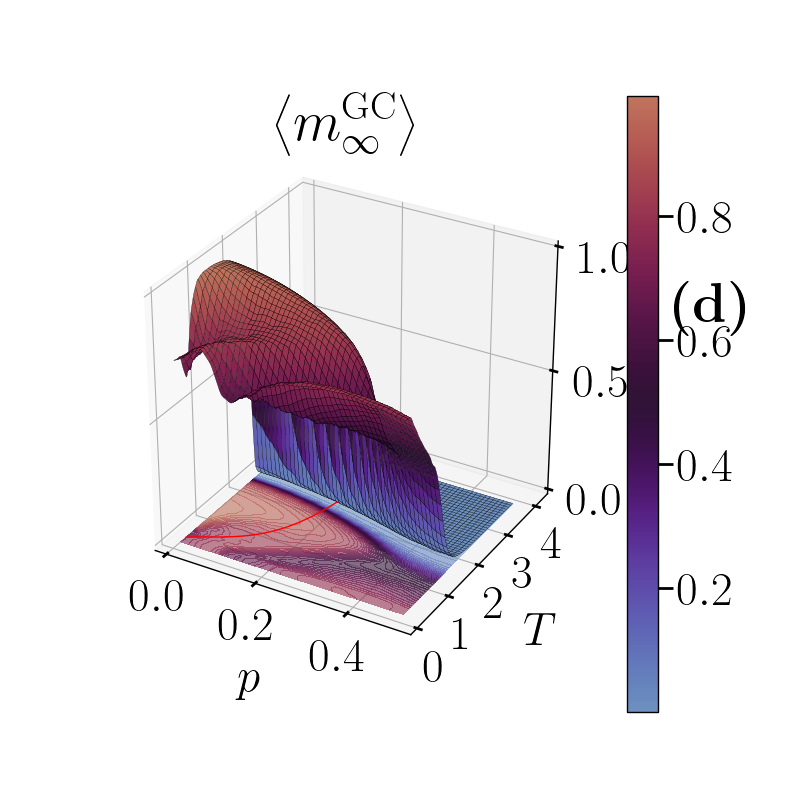

In [23]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
im = ax.plot_surface(x, y, z_smoothed, cmap=restr_twilight, 
                edgecolor='k', lw=0.2)

ax.set_xlabel(r'$p$', labelpad=20)
ax.set_ylabel(r'$T$', labelpad=20)
ax.set_title(r'$\avg*{m_{\infty}^{\mathrm{GC}}}$')
ax.set_zticks([0, 0.5, 1])
ax.set_yticks(np.linspace(0, 4, num=5))
# ax.view_init(elev=25, azim=-60)
ax.set_box_aspect([1,1,1])
ax.zaxis.set_tick_params(pad=15)
ax.set_zlim(0, 1)
ax.text(1, 0, 1.4, r'\textbf{(d)}', fontsize=40, 
                fontweight='bold', color='black')

ax.contourf(x, y, z_smoothed, zdir='z', offset=0, cmap=restr_twilight, alpha=0.6, levels=50)  # Projection on z=0


def T(p):
    return 1 / np.log((1 / (2 * p)) - 1)

# Define p_values and T(p) for plotting the line on the surface
p_values = np.linspace(0.01, 0.22, 100)  # finer sampling for a smoother line
T_values = T(p_values)

# Plotting T(p) line over the surface
ax.plot(p_values, T_values, ls='-', zs=0, marker='', zdir='z', color='r', lw=1, zorder=3)  # Plotted at the top with red color


fig.colorbar(im)
# fig.savefig(os.path.join(path_panel4, 'panel_4d_2.pdf'), 
#             bbox_inches='tight', transparent=True)

In [ ]:
def gen_valid_lines(filename):
    """ Generator that yields only valid lines with exactly two numeric entries. """
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:  # Only yield lines with exactly two numeric entries
                try:
                    # Convert to float to ensure they are numeric
                    float(parts[0]), float(parts[1])
                    yield line
                except ValueError:
                    continue  # Skip lines that cannot be converted to float
def read_and_compute_variance(filepath):
    """ Reads a two-column file and computes the variance of the first column. """
    data = np.loadtxt(gen_valid_lines(filepath))
    mask = np.abs(data) <= 1
    filtered_array = data[mask]
    return np.mean(np.abs(filtered_array))
def prepare_data_for_plotting(search_dir, custromstr=''):
    filenames = os.listdir(search_dir)
    if custromstr:
        filenames = [f for f in filenames if custromstr in f]
    p_values = set(extract_values_from_filenames(filenames, r"p=([\d.]+)"))
    T_values = set(extract_values_from_filenames(filenames, r"T=([\d.]+)"))
    
    # Create a meshgrid for p and T
    P, T = np.meshgrid(sorted(p_values), sorted(T_values))
    variance_matrix = np.zeros(P.shape)
    
    # Map filenames to their p and T values
    file_map = {}
    for filename in filenames:
        p = float(re.search(r"p=([\d.]+)", filename).group(1))
        t = float(re.search(r"T=([\d.]+)", filename).group(1))
        file_map[(p, t)] = filename

    # Compute variance for each p, T combination
    for (i, j), p in np.ndenumerate(P):
        t = T[i, j]
        try:
            filepath = os.path.join(search_dir, file_map.get((p, t)))
        except:
            continue
        if filepath:
            variance_matrix[i, j] = read_and_compute_variance(filepath)
    
    return P, T, variance_matrix

def plot_surface(P, T, variances, elev=10, azim=40, T_value=2.2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(P, T, variances, cmap=restr_twilight, edgecolor='k', lw=0.2, rasterized=True)
    clb = fig.colorbar(surf, ax=ax, pad=0, shrink=0.8)
    # fig.colorbar(surf, ax=ax, label=r'$\avg*{m_{\infty}^{\mathrm{GC}}}$')
    ax.set_xlabel('$p$', labelpad=30)
    ax.set_ylabel('$T$', labelpad=30)
    ax.set_zlim(0, 1)
    ax.zaxis.set_tick_params(pad=15)  # Increase pad to move labels away from the axis
    intersection_z = variances[T == T_value]
    ax.scatter(P[T == T_value], np.full_like(intersection_z, T_value), intersection_z, color='black')

    ax.set_box_aspect([1,1,1])  # Axes are in a 1:1:1 ratio
    ax.set_title(r'$\avg*{m_{\infty}^{\mathrm{GC}}}$')
    ax.view_init(elev=elev, azim=azim)
    fig.tight_layout()
    return fig, ax



In [ ]:
# Assuming the directory path is stored in `isingpath`
P, T, variances = prepare_data_for_plotting(l.isingpath, custromstr=sffx)
P_new, T_new, variances_new = interpolate_grid_data(P, T, variances)

fig, ax = plot_surface(P_new, T_new, variances_new, elev=10, azim=50)
fig.savefig(os.path.join(plotpath, f'magnGC_surface_{sffx}.pdf'), 
            bbox_inches='tight', transparent=True)